<a href="https://colab.research.google.com/github/Venture-Coding/Linkedin_Learning/blob/main/Transfer%20Learning/Fixed_Feature_Extractor_using_VGG_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning - Fixed Feature Extractor : VGG-16


## Creating and using a Fixed Feature Extractor


In [1]:
# Setting seeds to try and ensure we have the same results - this is not guaranteed across PyTorch releases.
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

**CUDA** is a **parallel computing platform** and application programming interface that allows software to use certain types of graphics processing unit for general purpose processing – an approach called general-purpose computing on GPUs. Developed by NVIDIA - Wiki

In [4]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    ])

trainset = datasets.CIFAR10(root='~/.pytorch/CIFAR10',train=True, download=True,transform=transform)
testset = datasets.CIFAR10(root='~/.pytorch/CIFAR10',train=False, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /root/.pytorch/CIFAR10/cifar-10-python.tar.gz to /root/.pytorch/CIFAR10


In [5]:
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [6]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [7]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [8]:
for param in model.parameters():
  param.requires_grad = False

False , for using the model as a Fixed Feature Extractor by removing the last fully connected layer.  
A way of freezing the earlier layers of VGG to use the pre-trained weights that it has already learnt from it's database of millions of images. We will only update the weights of the last fully connected layer using our Working Dataset.

In [9]:
model.classifier[-1] = nn.Sequential(
                       nn.Linear(in_features=4096, out_features=10),
                       nn.LogSoftmax(dim=1)
                        )

Takes the new Linear layer with LogSoftmax and puts it at the last place in the model.   
Notice we are changing out_features to 10, as we have 10 classes and adding the activation.

In [10]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=10, bias=True)
    (1): LogSoftmax(dim=1)
  )
)

In [11]:
criterion = nn.NLLLoss()

NLL loss - Negative LogLikelihood Loss.  
There's also CrossEntropy loss, if that's used we don't need LogSoftmax in the last layer. Pytorch's implementation includes both.



## Training the Fixed Feature Extractor

Steps :  
1. Take a batch of images and target variables.
2. Forward Pass
3. Calculate loss of network on batch
4. Backward Pass
5. Update weights of the required layers (unfrozen layers)(using gradients of the loss) w = w - lr*grad_of_loss
6. Take a step with the optmizer, in the right direction. :) 
7. Don't forget to zero out the gradients if training multiple batches, to keep each of them independent.


In [12]:
from torch.optim import Adam

model = model.to(device)
optimizer = Adam(model.parameters())

Adam is an extension of SGD, quite some differences but not major. Adamw also released to cover some limitations of adam.

In [13]:
num_epochs = 1
batch_loss = 0
cum_epoch_loss = 0 #cumulative losses over the epochs

for e in range(num_epochs):
  cum_epoch_loss = 0
  
  for batch, (images, labels) in enumerate(trainloader,1):
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad() #since gradients are also accumulated while doing multiple backward passes with same parameters, 
                          # hence, need to zero them out for each batch.
    logps = model(images) # predictions
    loss = criterion(logps, labels) #loss based on mismatch of predicted and true
    loss.backward()
    optimizer.step()      # optimize weights of the model
    
    batch_loss += loss.item()
    print(f'Epoch({e}/{num_epochs} : Batch number({batch}/{len(trainloader)})  Batch loss : {loss.item()}')
    #printing the average loss for the batch.
  print(f'Training loss : {batch_loss/len(trainloader)}')  
    

Epoch(0/1 : Batch number(1/782)  Batch loss : 2.3901445865631104
Epoch(0/1 : Batch number(2/782)  Batch loss : 2.1255316734313965
Epoch(0/1 : Batch number(3/782)  Batch loss : 2.0556581020355225
Epoch(0/1 : Batch number(4/782)  Batch loss : 1.8978369235992432
Epoch(0/1 : Batch number(5/782)  Batch loss : 1.7002276182174683
Epoch(0/1 : Batch number(6/782)  Batch loss : 1.6189216375350952
Epoch(0/1 : Batch number(7/782)  Batch loss : 1.510068655014038
Epoch(0/1 : Batch number(8/782)  Batch loss : 1.3458189964294434
Epoch(0/1 : Batch number(9/782)  Batch loss : 1.312595248222351
Epoch(0/1 : Batch number(10/782)  Batch loss : 1.2988550662994385
Epoch(0/1 : Batch number(11/782)  Batch loss : 1.2341896295547485
Epoch(0/1 : Batch number(12/782)  Batch loss : 1.2216652631759644
Epoch(0/1 : Batch number(13/782)  Batch loss : 1.0582250356674194
Epoch(0/1 : Batch number(14/782)  Batch loss : 0.9364659190177917
Epoch(0/1 : Batch number(15/782)  Batch loss : 1.0799226760864258
Epoch(0/1 : Batch num

## Evaluating the network and viewing images

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [15]:
CIFAR10_classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


model.to('cpu') #on training we need model on GPU, 
                #to evaluate/inference, we can do it on our cpu

model.eval() 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

We usually don't need this model.eval(), as normally pytorch runs a network model in train mode, *if no dropout/batch normalisation*.

But since vgg 16 has a dropout layer, we need to explicitly set to "eval" mode before computing the output values.

Bcuz during training, a **drop out layer, randomly sets any/some of it inputs to zero**; which effectively erases them from the network, this make the finely-trained **network more robust** and **less** prone to overfitting.



In [16]:
with torch.no_grad():
  images, labels = next(iter(testloader))
  logps = model(images)
  
  output = torch.exp(logps)
  print(output)


tensor([[6.4039e-04, 1.0855e-02, 1.2875e-03, 7.7311e-01, 3.5930e-04, 3.2321e-02,
         1.7434e-01, 6.0841e-03, 7.2985e-04, 2.7300e-04],
        [1.3347e-02, 1.7900e-01, 5.1526e-05, 7.4468e-05, 8.5632e-07, 7.4796e-06,
         5.1130e-06, 6.5271e-06, 8.0627e-01, 1.2352e-03],
        [1.5944e-03, 2.8035e-03, 9.3020e-07, 3.3235e-06, 4.5233e-07, 1.4053e-07,
         1.1405e-07, 5.1494e-06, 9.9545e-01, 1.4610e-04],
        [4.3544e-01, 1.0295e-03, 5.9684e-02, 9.2777e-02, 6.5315e-04, 1.1365e-03,
         3.0267e-03, 3.2557e-03, 4.0260e-01, 4.0206e-04],
        [2.7520e-08, 3.9796e-07, 2.4135e-03, 3.2272e-04, 1.5428e-04, 8.6983e-06,
         9.9710e-01, 6.8706e-07, 7.2332e-08, 1.6337e-07],
        [5.7466e-06, 3.4879e-06, 7.1237e-05, 1.7720e-01, 1.7810e-02, 7.7967e-02,
         7.2464e-01, 2.2588e-03, 5.1002e-07, 4.5706e-05],
        [2.1850e-05, 9.9003e-01, 9.0432e-07, 9.9994e-05, 2.2661e-08, 1.5765e-04,
         3.9578e-06, 6.9710e-05, 1.4562e-05, 9.6022e-03],
        [1.7973e-02, 8.6891

In [18]:
CIFAR10_classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


model.to('cpu')

model.eval()

with torch.no_grad():
  images, labels = next(iter(testloader))
  logps = model(images)
  
  output = torch.exp(logps)
  
  pred = torch.argmax(output,1) # as we just wanted the highest predicted value's index for each image.
                                 # the index corresponds to the relevant class in CIFAR10
    
model.train() #switching back to default train mode, in pytorch.

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

cat


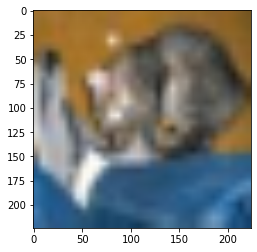

In [19]:
test_image_id=0

def denormalize(tensor):
  tensor = tensor*std+ mean
  return tensor

def show_img(img):
  img = img.numpy().transpose((1,2,0))
  img = denormalize(img)
  img = np.clip(img,0,1)
  plt.imshow(img)
  
def get_CIFAR10_class(id):
  CIFAR10_classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
  return CIFAR10_classes[id]

show_img(images[test_image_id])
print(get_CIFAR10_class(pred[test_image_id]))

## Viewing images & normalization - Under the hood

In [20]:
pred # understanding what pred holds

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5, 4, 3, 9, 5, 4, 1, 9, 5, 2, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 8, 3, 8, 8, 7, 3, 3, 3, 7, 3, 6, 3])

In [21]:
images.size()

torch.Size([64, 3, 224, 224])

In [22]:
images[0].size()

torch.Size([3, 224, 224])

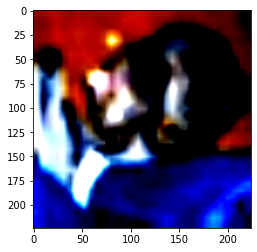

In [24]:
plt.imshow(np.clip(np.transpose(images[test_image_id],(1,2,0)),0,1))

z = (x - mean) / std #Z score

In [25]:
def denormalize(tensor):
  tensor = tensor*std + mean
  return tensor #so that tensor is the Z - score

In [29]:
def show_img(img):
  img = img.numpy().transpose((1,2,0))
  img = denormalize(img)
  img = np.clip(img,0,1) #clipped between 0 and 1 as shown above
  plt.imshow(img)

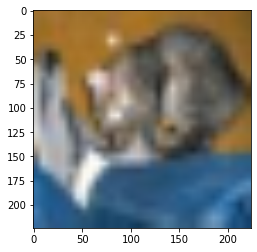

In [30]:
show_img(images[test_image_id]) # looks much better normalised

In [31]:
def get_CIFAR10_class(id):
  CIFAR10_classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
  return CIFAR10_classes[id] #which member of the class is it, returned
  

In [28]:
get_CIFAR10_class(pred[test_image_id])

'cat'

## Accuracy of the model

In [36]:
model.eval()         #bcuz there's dropout layer
with torch.no_grad(): #no need to calc gradient as we arent training yet
    num_correct = 0   #store the numbers where the pred matches true labels
    total = 0         #tracks the number of images we r testing

    cnt = 0
    #set_trace()
    for images, labels in testloader:
        
        logps = model(images)     #forward pass and pred stored in logps
        output = torch.exp(logps) #since those are log values, need to convert to exponent to get probability
        print(output)             
        cnt+=1
        
        if cnt > 0:   # to ensure the loop runs fine, failsafe!
          break

tensor([[6.4039e-04, 1.0855e-02, 1.2875e-03, 7.7311e-01, 3.5930e-04, 3.2321e-02,
         1.7434e-01, 6.0841e-03, 7.2985e-04, 2.7300e-04],
        [1.3347e-02, 1.7900e-01, 5.1526e-05, 7.4468e-05, 8.5632e-07, 7.4796e-06,
         5.1130e-06, 6.5271e-06, 8.0627e-01, 1.2352e-03],
        [1.5944e-03, 2.8035e-03, 9.3020e-07, 3.3235e-06, 4.5233e-07, 1.4053e-07,
         1.1405e-07, 5.1494e-06, 9.9545e-01, 1.4610e-04],
        [4.3544e-01, 1.0295e-03, 5.9684e-02, 9.2777e-02, 6.5315e-04, 1.1365e-03,
         3.0267e-03, 3.2557e-03, 4.0260e-01, 4.0206e-04],
        [2.7520e-08, 3.9796e-07, 2.4135e-03, 3.2272e-04, 1.5428e-04, 8.6983e-06,
         9.9710e-01, 6.8706e-07, 7.2332e-08, 1.6337e-07],
        [5.7466e-06, 3.4879e-06, 7.1237e-05, 1.7720e-01, 1.7810e-02, 7.7967e-02,
         7.2464e-01, 2.2588e-03, 5.1002e-07, 4.5706e-05],
        [2.1850e-05, 9.9003e-01, 9.0432e-07, 9.9994e-05, 2.2661e-08, 1.5765e-04,
         3.9578e-06, 6.9710e-05, 1.4562e-05, 9.6022e-03],
        [1.7973e-02, 8.6891

In [37]:
pred,labels

(tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
         5, 2, 4, 0, 9, 6, 6, 5, 4, 3, 9, 5, 4, 1, 9, 5, 2, 6, 5, 6, 0, 9, 3, 9,
         7, 6, 9, 8, 8, 3, 8, 8, 7, 3, 3, 3, 7, 3, 6, 3]),
 tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
         5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9,
         7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3]))

In [38]:
pred == labels

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True, False,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True, False, False, False,
         True,  True,  True,  True])

In [40]:
model.eval()
with torch.no_grad():
    num_correct = 0
    total = 0


    for batch, (images, labels) in enumerate(testloader,1):
        
        logps = model(images)
        output = torch.exp(logps)
        
        pred = torch.argmax(output, 1)
        total += labels.size(0)
        num_correct += (pred == labels).sum().item() #summing right preds, to get total number of corrects, the item() method gives number from a tensor containing single value
        print(f'Batch ({batch}/{len(testloader)})')
        
        if batch == 5:
          break

    print(f'Accuracy of the model on {total} test images: {num_correct * 100 / total}% ')

Batch (1/157)
Batch (2/157)
Batch (3/157)
Batch (4/157)
Batch (5/157)
Accuracy of the model on 320 test images: 79.6875% 


Training with only **one epoch** and just **limited data** of images, we still have the accuracy of ~80%. That's the benefit of transfer learning.